In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


import warnings
import os
import numpy as np
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, balanced_accuracy_score,
                            f1_score, accuracy_score, precision_score,
                            recall_score, confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
from tqdm import tqdm
import cv2

warnings.filterwarnings("ignore")

# ####################################################
#  VERI KLASÖRÜ
# ####################################################
path = '/content/drive/MyDrive/Data'
fer2013_test_path = '/content/drive/MyDrive/test'  # FER2013 test klasörü
print(f"Dataset Path: {path}")
print(f"FER2013 Test Path: {fer2013_test_path}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')




Dataset Path: /content/drive/MyDrive/Data
FER2013 Test Path: /content/drive/MyDrive/test
Using device: cuda


In [ ]:
# ----------------------------------------------------
# DATASET SINIFI
# ----------------------------------------------------
class EmotionDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # grayscale
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label, img_path


# ----------------------------------------------------
# DATASET YÜKLEME
# ----------------------------------------------------
def load_dataset(data_path):
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(data_path))
    class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_path = os.path.join(data_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(img_path)
                    labels.append(class_to_idx[class_name])

    return image_paths, labels, class_names


def load_fer2013_test(fer_test_path, class_mapping):
    """FER2013 test setini yükle (sadece belirtilen 5 sınıf)"""
    image_paths = []
    labels = []

    # FER2013'teki sınıf isimleri (küçük harfle)
    fer_classes = ['angry', 'fear', 'happy', 'sad', 'suprise']

    for class_name in fer_classes:
        class_path = os.path.join(fer_test_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(img_path)
                    # Sınıf ismini eşleştir
                    labels.append(class_mapping[class_name])

    return image_paths, labels


print("Loading dataset...")
image_paths, labels, class_names = load_dataset(path)
print(f"Total images: {len(image_paths)}")
print(f"Classes: {class_names}")




Loading dataset...
Total images: 59099
Classes: ['Angry', 'Fear', 'Happy', 'Sad', 'Suprise']


In [ ]:
# ----------------------------------------------------
# TRAIN / VAL / TEST SPLIT (70 / 10 / 20)
# ----------------------------------------------------
X_temp, X_test, y_temp, y_test = train_test_split(
    image_paths, labels, test_size=0.2, random_state=123, stratify=labels
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, random_state=123, stratify=y_temp
)

print(f"Train size: {len(X_train)}, Val size: {len(X_val)}, Test size: {len(X_test)}")


# ----------------------------------------------------
# TRANSFORMS (224x224, NORMALIZATION)
# ----------------------------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


train_dataset = EmotionDataset(X_train, y_train, transform=transform)
val_dataset = EmotionDataset(X_val, y_val, transform=transform)
test_dataset = EmotionDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)


# ----------------------------------------------------
# FER2013 TEST DATASET
# ----------------------------------------------------
# Sınıf eşleştirmesi (FER2013 -> Bizim model)
class_mapping = {name.lower(): idx for idx, name in enumerate(class_names)}
# FER2013 datasetindeki 'surprise' sınıfının, ana datasetimizdeki 'suprise' ile eşleşmesini sağla.
# Eğer ana datasetimizde 'suprise' varsa ve FER2013'ün 'surprise'ı eksikse ekle.
if 'suprise' in class_mapping and 'surprise' not in class_mapping:
    class_mapping['surprise'] = class_mapping['suprise']
print(f"\nClass mapping: {class_mapping}")

print("\nLoading FER2013 test dataset...")
fer2013_image_paths, fer2013_labels = load_fer2013_test(fer2013_test_path, class_mapping)
print(f"FER2013 Test images: {len(fer2013_image_paths)}")

fer2013_dataset = EmotionDataset(fer2013_image_paths, fer2013_labels, transform=transform)
fer2013_loader = DataLoader(fer2013_dataset, batch_size=64, shuffle=False, num_workers=4)


# ----------------------------------------------------
# MODEL - CNN (Orijinal Kodunuzdaki Mimari)
# ----------------------------------------------------
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(EmotionCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.3)

        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)

        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 14 * 14, 512) # Corrected from 128 * 8 * 8
        self.bn7 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)

        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout1(x)

        x = self.relu(self.bn5(self.conv5(x)))
        x = self.pool3(x)

        x = self.relu(self.bn6(self.conv6(x)))
        x = self.pool4(x)

        x = self.flatten(x)
        x = self.relu(self.bn7(self.fc1(x)))
        x = self.dropout2(x)
        x = self.fc2(x)

        return x


model = EmotionCNN(num_classes=len(class_names)).to(device)
print(model)


Train size: 41369, Val size: 5910, Test size: 11820

Class mapping: {'angry': 0, 'fear': 1, 'happy': 2, 'sad': 3, 'suprise': 4, 'surprise': 4}

Loading FER2013 test dataset...
FER2013 Test images: 0
EmotionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stri

In [ ]:
# ----------------------------------------------------
# LOSS / OPTIMIZER
# ----------------------------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3
)


# ----------------------------------------------------
# TRAIN + VAL FONKSİYONLARI
# ----------------------------------------------------
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for inputs, labels, _ in tqdm(dataloader, desc='Training', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

    return running_loss / total, correct / total


def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for inputs, labels, _ in tqdm(dataloader, desc='Validation', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()

    return running_loss / total, correct / total


# ----------------------------------------------------
# TRAINING LOOP
# ----------------------------------------------------
print("\nTraining started...")
num_epochs = 50
patience = 10
best_val_loss = float('inf')
patience_counter = 0

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    start_time = time.time()

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    epoch_time = time.time() - start_time

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(
        f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} || "
        f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} || "
        f"Epoch Time: {epoch_time:.2f} sec"
    )

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'cnn_emotion_model.pth')
        print(f"Best model saved (Val Loss: {val_loss:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break





Training started...

Epoch 1/50


Train Loss: 1.1895 | Train Acc: 0.5205 || Val Loss: 0.9838 | Val Acc: 0.6112 || Epoch Time: 2939.59 sec
Best model saved (Val Loss: 0.9838)

Epoch 2/50


Train Loss: 0.8846 | Train Acc: 0.6605 || Val Loss: 0.8379 | Val Acc: 0.6878 || Epoch Time: 246.95 sec
Best model saved (Val Loss: 0.8379)

Epoch 3/50


Train Loss: 0.6861 | Train Acc: 0.7524 || Val Loss: 0.7106 | Val Acc: 0.7428 || Epoch Time: 245.84 sec
Best model saved (Val Loss: 0.7106)

Epoch 4/50


Train Loss: 0.5075 | Train Acc: 0.8284 || Val Loss: 0.5884 | Val Acc: 0.8039 || Epoch Time: 250.81 sec
Best model saved (Val Loss: 0.5884)

Epoch 5/50


Train Loss: 0.3600 | Train Acc: 0.8877 || Val Loss: 0.5096 | Val Acc: 0.8364 || Epoch Time: 243.87 sec
Best model saved (Val Loss: 0.5096)

Epoch 6/50


Train Loss: 0.2558 | Train Acc: 0.9249 || Val Loss: 0.4637 | Val Acc: 0.8584 || Epoch Time: 246.77 sec
Best model saved (Val Loss: 0.4637)

Epoch 7/50


Train Loss: 0.1899 | Train Acc: 0.9465 || Val Loss: 0.4384 | Val Acc: 0.8689 || Epoch Time: 246.31 sec
Best model saved (Val Loss: 0.4384)

Epoch 8/50


Train Loss: 0.1450 | Train Acc: 0.9624 || Val Loss: 0.4544 | Val Acc: 0.8679 || Epoch Time: 245.43 sec

Epoch 9/50


Train Loss: 0.1163 | Train Acc: 0.9708 || Val Loss: 0.4585 | Val Acc: 0.8726 || Epoch Time: 246.41 sec

Epoch 10/50


Train Loss: 0.1040 | Train Acc: 0.9738 || Val Loss: 0.4240 | Val Acc: 0.8822 || Epoch Time: 247.28 sec
Best model saved (Val Loss: 0.4240)

Epoch 11/50


Train Loss: 0.0884 | Train Acc: 0.9776 || Val Loss: 0.4287 | Val Acc: 0.8822 || Epoch Time: 249.26 sec

Epoch 12/50


Train Loss: 0.0839 | Train Acc: 0.9779 || Val Loss: 0.4359 | Val Acc: 0.8827 || Epoch Time: 249.26 sec

Epoch 13/50


Train Loss: 0.0731 | Train Acc: 0.9814 || Val Loss: 0.4519 | Val Acc: 0.8805 || Epoch Time: 246.24 sec

Epoch 14/50


Train Loss: 0.0668 | Train Acc: 0.9830 || Val Loss: 0.4518 | Val Acc: 0.8782 || Epoch Time: 244.44 sec

Epoch 15/50


Train Loss: 0.0456 | Train Acc: 0.9892 || Val Loss: 0.4349 | Val Acc: 0.8831 || Epoch Time: 249.13 sec

Epoch 16/50


Train Loss: 0.0368 | Train Acc: 0.9926 || Val Loss: 0.4307 | Val Acc: 0.8848 || Epoch Time: 249.30 sec

Epoch 17/50


Train Loss: 0.0317 | Train Acc: 0.9935 || Val Loss: 0.4342 | Val Acc: 0.8860 || Epoch Time: 249.39 sec

Epoch 18/50


Train Loss: 0.0280 | Train Acc: 0.9946 || Val Loss: 0.4358 | Val Acc: 0.8844 || Epoch Time: 250.39 sec

Epoch 19/50


Train Loss: 0.0247 | Train Acc: 0.9953 || Val Loss: 0.4372 | Val Acc: 0.8849 || Epoch Time: 250.07 sec

Epoch 20/50


Train Loss: 0.0246 | Train Acc: 0.9955 || Val Loss: 0.4386 | Val Acc: 0.8846 || Epoch Time: 248.77 sec

Early stopping triggered at epoch 20



Best model loaded!
Training history saved!


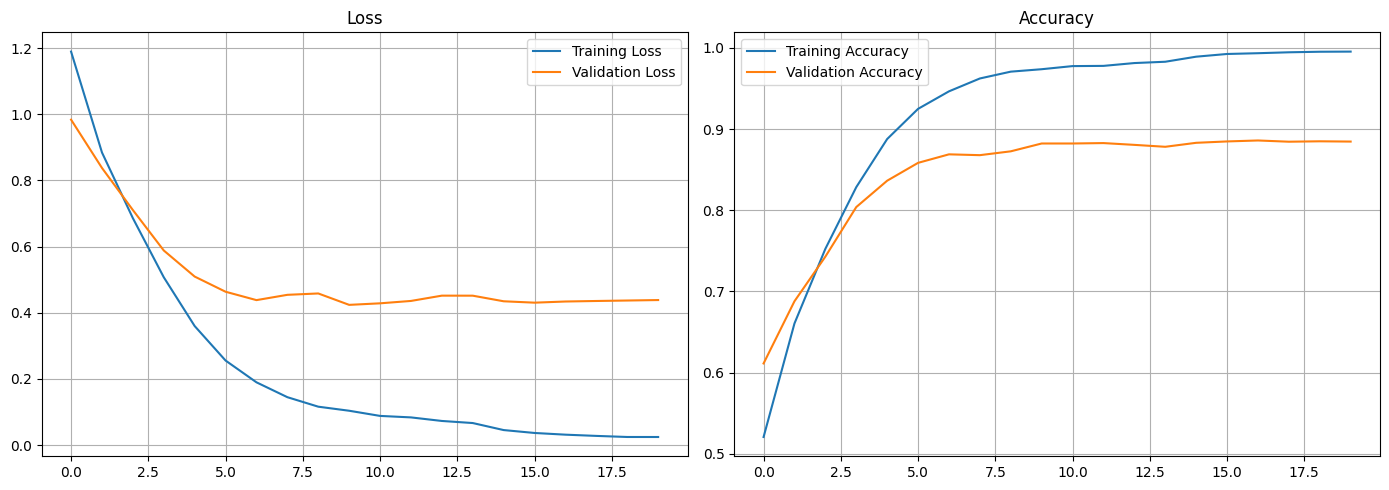

In [ ]:
# ----------------------------------------------------
# BEST MODEL YÜKLE
# ----------------------------------------------------
model.load_state_dict(torch.load('cnn_emotion_model.pth'))
print("\nBest model loaded!")

with open('training_history.json', 'w') as f:
    json.dump(history, f)

print("Training history saved!")


# ----------------------------------------------------
# PLOT - Loss ve Accuracy Grafikleri
# ----------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history['train_loss'], label='Training Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.legend()
ax1.grid()
ax1.set_title("Loss")

ax2.plot(history['train_acc'], label='Training Accuracy')
ax2.plot(history['val_acc'], label='Validation Accuracy')
ax2.legend()
ax2.grid()
ax2.set_title("Accuracy")

plt.tight_layout()
plt.savefig('training_plots.png', dpi=300)
plt.show()


# ----------------------------------------------------
# TEST EVALUATION FONKSİYONLARI
# ----------------------------------------------------
def evaluate_test(model, dataloader, device):
    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for inputs, labels, _ in tqdm(dataloader, desc='Testing', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, pred = outputs.max(1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(pred.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)


def calculate_sensitivity_specificity(y_true, y_pred, num_classes):
    """Her sınıf için sensitivity ve specificity hesapla"""
    cm = confusion_matrix(y_true, y_pred)

    sensitivity = []
    specificity = []

    for i in range(num_classes):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = cm.sum() - (tp + fn + fp)

        sens = tp / (tp + fn) if (tp + fn) > 0 else 0
        sensitivity.append(sens)

        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity.append(spec)

    return sensitivity, specificity


def print_detailed_metrics(y_true, y_pred, class_names, dataset_name):
    """Detaylı metrikleri yazdır"""
    print("\n" + "="*80)
    print(f"{dataset_name} - TEST SET RESULTS")
    print("="*80)

    # Classification Report
    print("\n📊 CLASSIFICATION REPORT:")
    print("-"*80)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # Balanced Accuracy
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    print(f"\n🎯 BALANCED ACCURACY: {bal_acc:.4f}")

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"📈 ACCURACY: {acc:.4f}")

    # Class-wise Sensitivity ve Specificity
    sensitivity, specificity = calculate_sensitivity_specificity(y_true, y_pred, len(class_names))

    print("\n📈 CLASS-WISE METRICS:")
    print("-"*80)
    print(f"{'Class':<20} {'Sensitivity':<15} {'Specificity':<15}")
    print("-"*80)
    for i, class_name in enumerate(class_names):
        print(f"{class_name:<20} {sensitivity[i]:<15.4f} {specificity[i]:<15.4f}")

    print("-"*80)
    print(f"{'AVERAGE':<20} {np.mean(sensitivity):<15.4f} {np.mean(specificity):<15.4f}")

    return bal_acc, sensitivity, specificity


def plot_confusion_matrix(y_true, y_pred, class_names, dataset_name):
    """Confusion matrix çiz"""
    cm = confusion_matrix(y_true, y_pred)

    # Raw confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'{dataset_name} - Confusion Matrix', fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{dataset_name.lower().replace(" ", "_")}.png', dpi=300)
    plt.show()

    # Normalized confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Percentage'})
    plt.title(f'{dataset_name} - Normalized Confusion Matrix', fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_normalized_{dataset_name.lower().replace(" ", "_")}.png', dpi=300)
    plt.show()

    return cm





Best model loaded!
Training history saved!


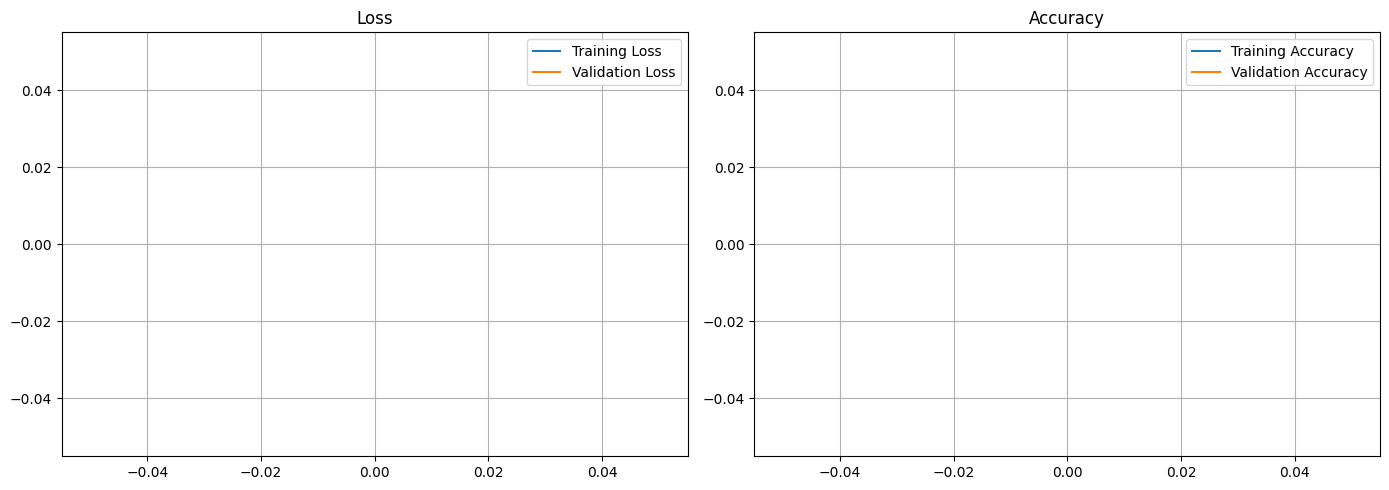


EVALUATING ON ORIGINAL TEST SET



Original Test Set - TEST SET RESULTS

📊 CLASSIFICATION REPORT:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

       Angry     0.8264    0.8419    0.8341      2030
        Fear     0.8647    0.7883    0.8247      1946
       Happy     0.9335    0.9330    0.9333      3688
         Sad     0.8443    0.8447    0.8445      2511
     Suprise     0.8590    0.9295    0.8928      1645

    accuracy                         0.8743     11820
   macro avg     0.8656    0.8675    0.8659     11820
weighted avg     0.8745    0.8743    0.8739     11820


🎯 BALANCED ACCURACY: 0.8675
📈 ACCURACY: 0.8743

📈 CLASS-WISE METRICS:
--------------------------------------------------------------------------------
Class                Sensitivity     Specificity    
--------------------------------------------------------------------------------
Angry                0.8419          0.9633         
Fear                 0.7883

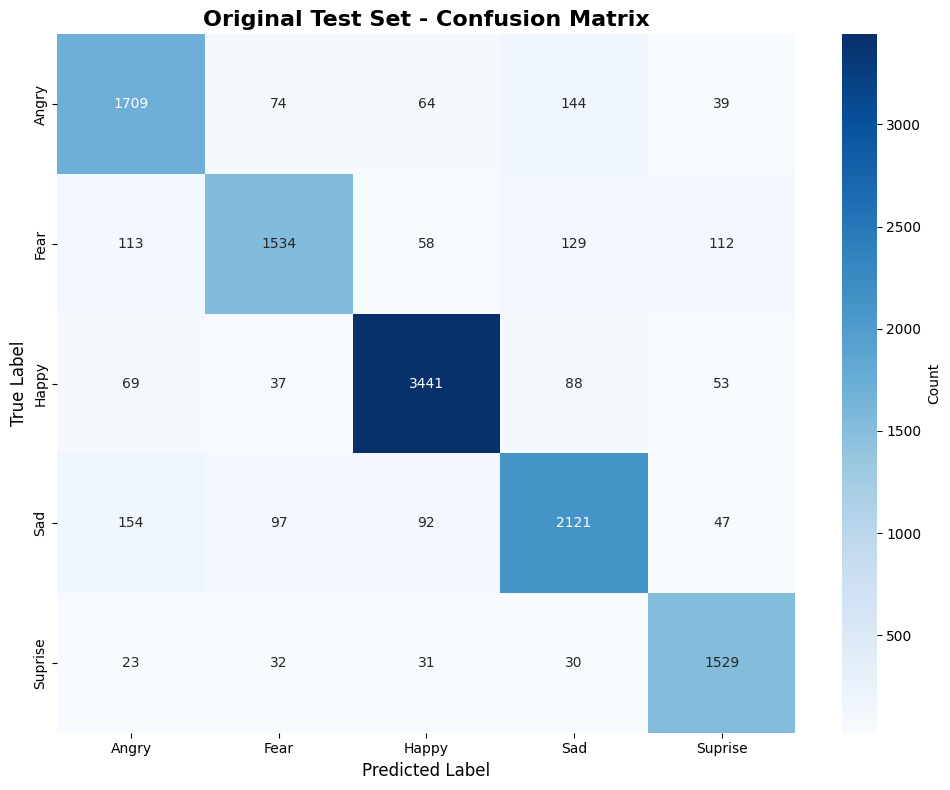

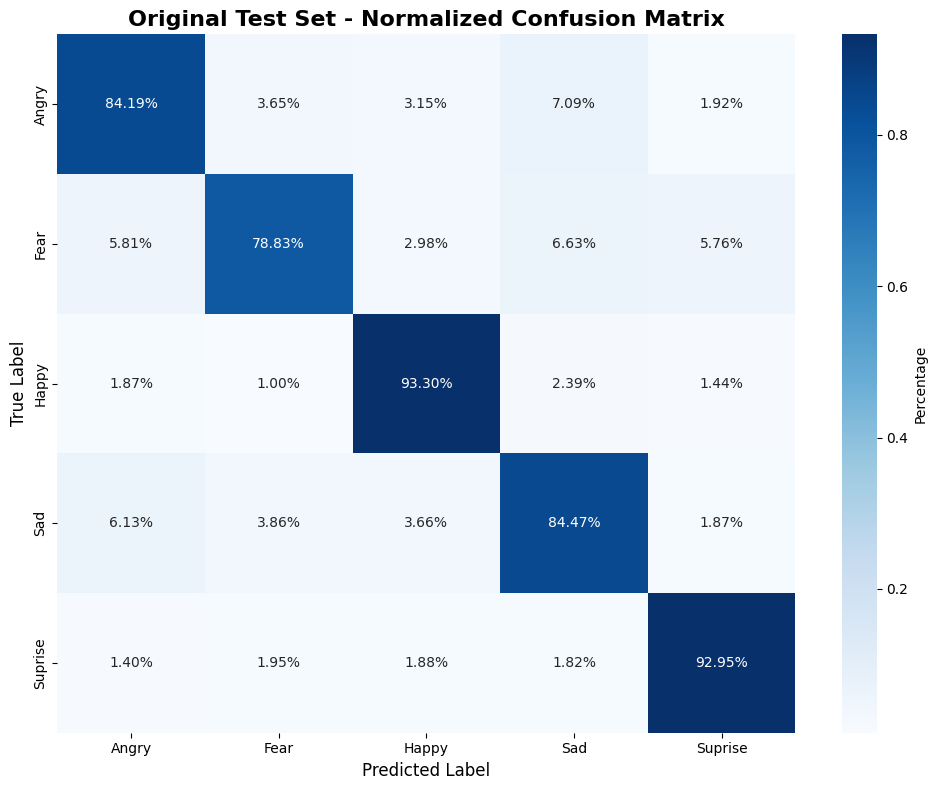

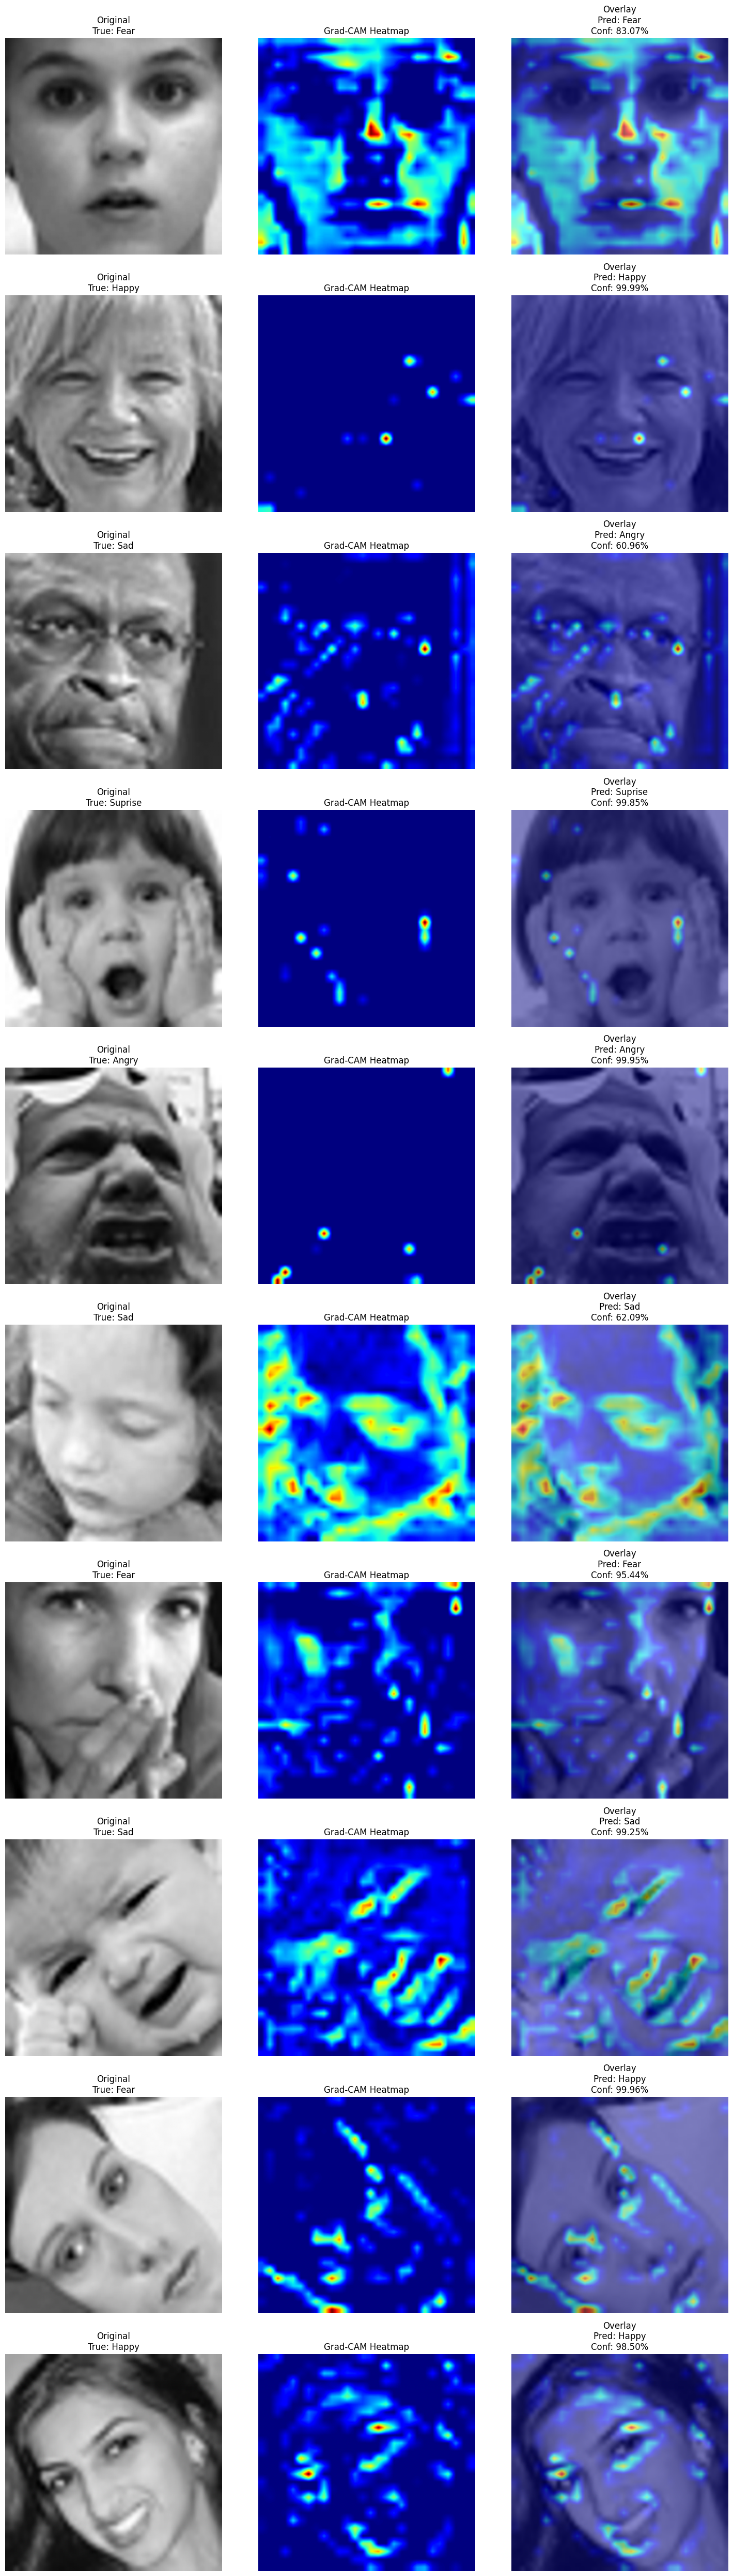


✅ Grad-CAM visualization saved: gradcam_original_test_set.png


In [ ]:
import warnings
import os
import numpy as np
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, balanced_accuracy_score,
                            f1_score, accuracy_score, precision_score,
                            recall_score, confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
from tqdm import tqdm
import cv2




# ----------------------------------------------------
# BEST MODEL YÜKLE
# ----------------------------------------------------
model.load_state_dict(torch.load('cnn_emotion_model.pth'))
print("\nBest model loaded!")

with open('training_history.json', 'w') as f:
    json.dump(history, f)

print("Training history saved!")


# ----------------------------------------------------
# PLOT - Loss ve Accuracy Grafikleri
# ----------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history['train_loss'], label='Training Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.legend()
ax1.grid()
ax1.set_title("Loss")

ax2.plot(history['train_acc'], label='Training Accuracy')
ax2.plot(history['val_acc'], label='Validation Accuracy')
ax2.legend()
ax2.grid()
ax2.set_title("Accuracy")

plt.tight_layout()
plt.savefig('training_plots.png', dpi=300)
plt.show()


# ----------------------------------------------------
# TEST EVALUATION FONKSİYONLARI
# ----------------------------------------------------
def evaluate_test(model, dataloader, device):
    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for inputs, labels, _ in tqdm(dataloader, desc='Testing', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, pred = outputs.max(1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(pred.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)


def calculate_sensitivity_specificity(y_true, y_pred, num_classes):
    """Her sınıf için sensitivity ve specificity hesapla"""
    cm = confusion_matrix(y_true, y_pred)

    sensitivity = []
    specificity = []

    for i in range(num_classes):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = cm.sum() - (tp + fn + fp)

        sens = tp / (tp + fn) if (tp + fn) > 0 else 0
        sensitivity.append(sens)

        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity.append(spec)

    return sensitivity, specificity


def print_detailed_metrics(y_true, y_pred, class_names, dataset_name):
    """Detaylı metrikleri yazdır"""
    print("\n" + "="*80)
    print(f"{dataset_name} - TEST SET RESULTS")
    print("="*80)

    # Classification Report
    print("\n📊 CLASSIFICATION REPORT:")
    print("-"*80)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # Balanced Accuracy
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    print(f"\n🎯 BALANCED ACCURACY: {bal_acc:.4f}")

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"📈 ACCURACY: {acc:.4f}")

    # Class-wise Sensitivity ve Specificity
    sensitivity, specificity = calculate_sensitivity_specificity(y_true, y_pred, len(class_names))

    print("\n📈 CLASS-WISE METRICS:")
    print("-"*80)
    print(f"{'Class':<20} {'Sensitivity':<15} {'Specificity':<15}")
    print("-"*80)
    for i, class_name in enumerate(class_names):
        print(f"{class_name:<20} {sensitivity[i]:<15.4f} {specificity[i]:<15.4f}")

    print("-"*80)
    print(f"{'AVERAGE':<20} {np.mean(sensitivity):<15.4f} {np.mean(specificity):<15.4f}")

    return bal_acc, sensitivity, specificity


def plot_confusion_matrix(y_true, y_pred, class_names, dataset_name):
    """Confusion matrix çiz"""
    cm = confusion_matrix(y_true, y_pred)

    # Raw confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'{dataset_name} - Confusion Matrix', fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{dataset_name.lower().replace(" ", "_")}.png', dpi=300)
    plt.show()

    # Normalized confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Percentage'})
    plt.title(f'{dataset_name} - Normalized Confusion Matrix', fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_normalized_{dataset_name.lower().replace(" ", "_")}.png', dpi=300)
    plt.show()

    return cm



# ============================================================
# GRAD-CAM IMPLEMENTATION
# ============================================================
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate_cam(self, input_image, target_class=None):
        model_output = self.model(input_image)

        # Determine the target class index (as an integer)
        if target_class is None:
            target_class_idx = model_output.argmax(dim=1).item()
        else:
            # If target_class is provided, ensure it's an integer.
            # It should already be an integer from visualize_gradcam, but handle tensor case too.
            target_class_idx = target_class.item() if isinstance(target_class, torch.Tensor) else target_class

        self.model.zero_grad()
        # Use the target_class_idx for backpropagation. PyTorch can index with an integer.
        class_loss = model_output[0, target_class_idx]
        class_loss.backward()

        gradients = self.gradients[0].cpu().numpy()
        activations = self.activations[0].cpu().numpy()

        weights = np.mean(gradients, axis=(1, 2))

        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = np.maximum(cam, 0)

        if cam.max() > 0:
            cam = cam / cam.max()

        return cam, target_class_idx # Return the integer class index


def apply_colormap_on_image(org_im, activation, colormap=cv2.COLORMAP_JET):
    """Grad-CAM'i orijinal görüntüye uygula"""
    heatmap = cv2.applyColorMap(np.uint8(255 * activation), colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255

    if len(org_im.shape) == 2:
        org_im = np.stack([org_im] * 3, axis=-1)

    cam = heatmap + np.float32(org_im)
    cam = cam / np.max(cam)

    return np.uint8(255 * cam)


def visualize_gradcam(model, dataloader, class_names, dataset_name, num_samples=10, device='cuda'):
    """Grad-CAM görselleştirme"""
    model.eval()

    # CNN için son conv katmanını seç (conv6)
    target_layer = model.conv6
    gradcam = GradCAM(model, target_layer)

    indices = np.random.choice(len(dataloader.dataset), min(num_samples, len(dataloader.dataset)), replace=False)

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for idx, sample_idx in enumerate(indices):
        img_tensor, true_label, img_path = dataloader.dataset[sample_idx]

        original_img = Image.open(img_path).convert('L')
        original_img_np = np.array(original_img.resize((224, 224))) / 255.0

        img_tensor = img_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img_tensor)
            pred_class = output.argmax(dim=1).item()
            confidence = torch.softmax(output, dim=1)[0, pred_class].item()

        cam, _ = gradcam.generate_cam(img_tensor, target_class=pred_class)
        cam_resized = cv2.resize(cam, (224, 224))

        visualization = apply_colormap_on_image(original_img_np, cam_resized)

        axes[idx, 0].imshow(original_img_np, cmap='gray')
        axes[idx, 0].set_title(f'Original\nTrue: {class_names[true_label]}')
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(cam_resized, cmap='jet')
        axes[idx, 1].set_title('Grad-CAM Heatmap')
        axes[idx, 1].axis('off')

        axes[idx, 2].imshow(visualization)
        axes[idx, 2].set_title(f'Overlay\nPred: {class_names[pred_class]}\nConf: {confidence:.2%}')
        axes[idx, 2].axis('off')

    plt.tight_layout()
    plt.savefig(f'gradcam_{dataset_name.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n✅ Grad-CAM visualization saved: gradcam_{dataset_name.lower().replace(' ', '_')}.png")


# ============================================================
# ORIGINAL TEST SET EVALUATION
# ============================================================
print("\n" + "="*80)
print("EVALUATING ON ORIGINAL TEST SET")
print("="*80)

y_true_orig, y_pred_orig = evaluate_test(model, test_loader, device)
bal_acc_orig, sens_orig, spec_orig = print_detailed_metrics(
    y_true_orig, y_pred_orig, class_names, "Original Test Set"
)
cm_orig = plot_confusion_matrix(y_true_orig, y_pred_orig, class_names, "Original Test Set")

# Grad-CAM visualization
visualize_gradcam(model, test_loader, class_names, "Original Test Set", num_samples=10, device=device)

# Save results
results_orig = {
    'dataset': 'Original Test Set',
    'balanced_accuracy': float(bal_acc_orig),
    'accuracy': float(accuracy_score(y_true_orig, y_pred_orig)),
    'class_names': class_names,
    'sensitivity': [float(s) for s in sens_orig],
    'specificity': [float(s) for s in spec_orig],
    'confusion_matrix': cm_orig.tolist()
}

with open('test_results_original.json', 'w') as f:
    json.dump(results_orig, f, indent=4)



EVALUATING ON FER2013 TEST SET



FER2013 Test Set - TEST SET RESULTS

📊 CLASSIFICATION REPORT:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

       Angry     0.9140    0.9541    0.9336       958
        Fear     0.9509    0.8691    0.9082      1024
       Happy     0.9764    0.9780    0.9772      1776
         Sad     0.9388    0.9471    0.9429      1247
     Suprise     0.9352    0.9712    0.9528       832

    accuracy                         0.9474      5837
   macro avg     0.9430    0.9439    0.9429      5837
weighted avg     0.9478    0.9474    0.9471      5837


🎯 BALANCED ACCURACY: 0.9439
📈 ACCURACY: 0.9474

📈 CLASS-WISE METRICS:
--------------------------------------------------------------------------------
Class                Sensitivity     Specificity    
--------------------------------------------------------------------------------
Angry                0.9541          0.9824         
Fear                 0.8691 

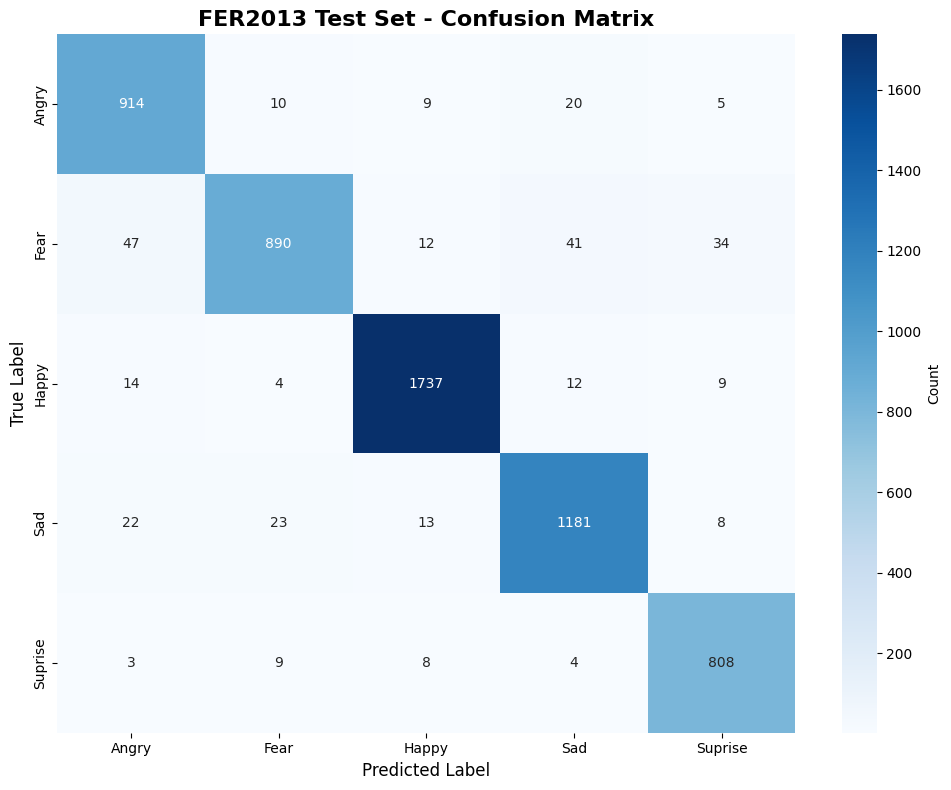

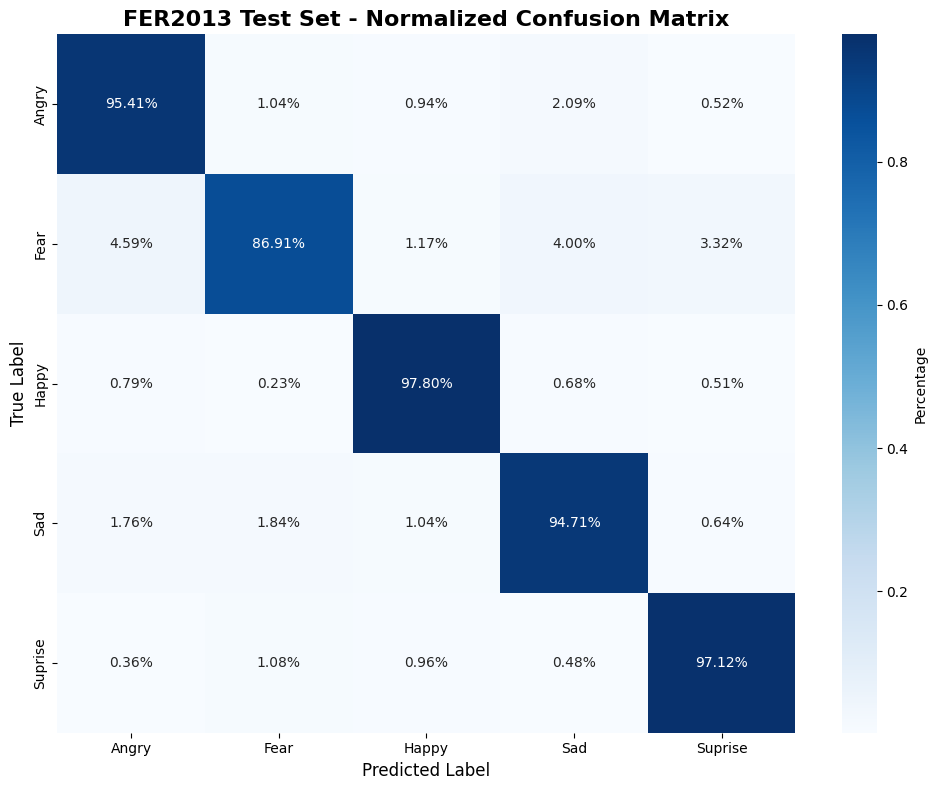

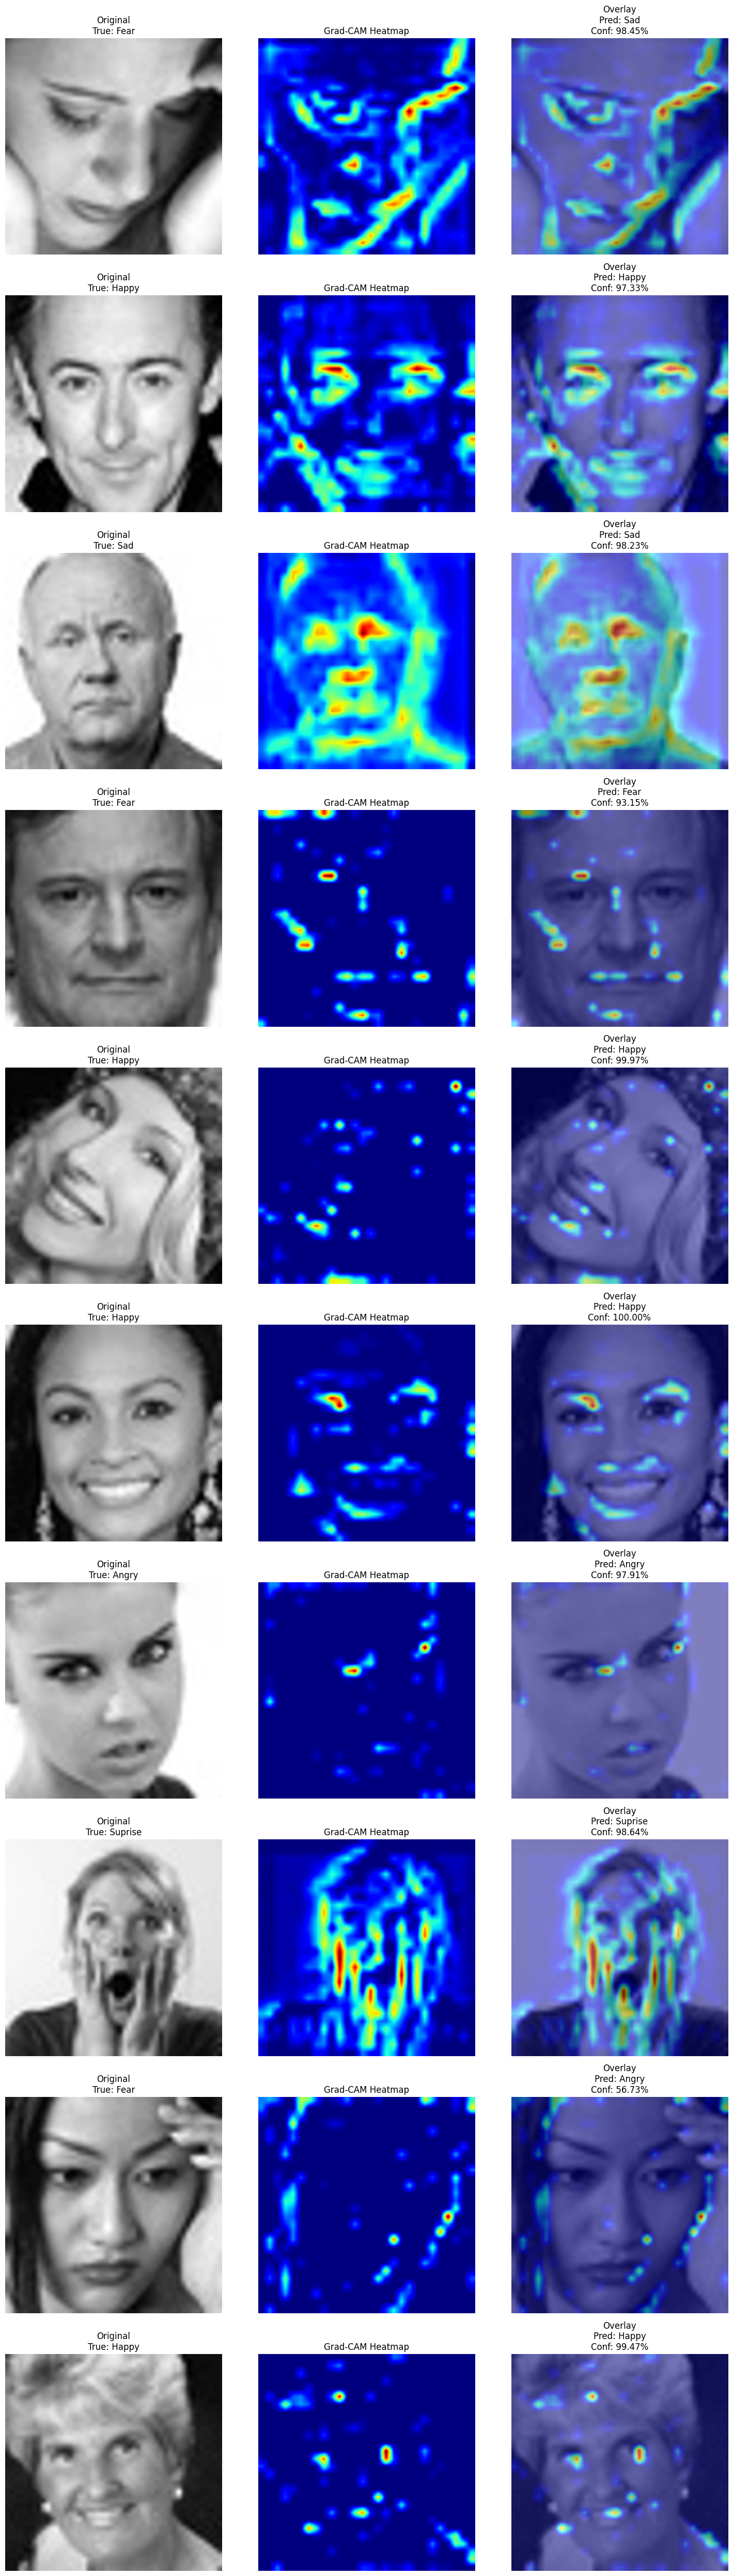


✅ Grad-CAM visualization saved: gradcam_fer2013_test_set.png

🎉 ALL PROCESSING COMPLETED!

Saved files:
  📁 Model:
     - cnn_emotion_model.pth
  📊 Training:
     - training_history.json
     - training_plots.png
  📈 Original Test Set:
     - test_results_original.json
     - confusion_matrix_original_test_set.png
     - confusion_matrix_normalized_original_test_set.png
     - gradcam_original_test_set.png
  📈 FER2013 Test Set:
     - test_results_fer2013.json
     - confusion_matrix_fer2013_test_set.png
     - confusion_matrix_normalized_fer2013_test_set.png
     - gradcam_fer2013_test_set.png


In [ ]:
# ============================================================
# FER2013 TEST SET EVALUATION
# ============================================================
print("\n" + "="*80)
print("EVALUATING ON FER2013 TEST SET")
print("="*80)

y_true_fer, y_pred_fer = evaluate_test(model, fer2013_loader, device)
bal_acc_fer, sens_fer, spec_fer = print_detailed_metrics(
    y_true_fer, y_pred_fer, class_names, "FER2013 Test Set"
)
cm_fer = plot_confusion_matrix(y_true_fer, y_pred_fer, class_names, "FER2013 Test Set")

# Grad-CAM visualization
visualize_gradcam(model, fer2013_loader, class_names, "FER2013 Test Set", num_samples=10, device=device)

# Save results
results_fer = {
    'dataset': 'FER2013 Test Set',
    'balanced_accuracy': float(bal_acc_fer),
    'accuracy': float(accuracy_score(y_true_fer, y_pred_fer)),
    'class_names': class_names,
    'sensitivity': [float(s) for s in sens_fer],
    'specificity': [float(s) for s in spec_fer],
    'confusion_matrix': cm_fer.tolist()
}

with open('test_results_fer2013.json', 'w') as f:
    json.dump(results_fer, f, indent=4)


print("\n" + "="*80)
print("🎉 ALL PROCESSING COMPLETED!")
print("="*80)
print("\nSaved files:")
print("  📁 Model:")
print("     - cnn_emotion_model.pth")
print("  📊 Training:")
print("     - training_history.json")
print("     - training_plots.png")
print("  📈 Original Test Set:")
print("     - test_results_original.json")
print("     - confusion_matrix_original_test_set.png")
print("     - confusion_matrix_normalized_original_test_set.png")
print("     - gradcam_original_test_set.png")
print("  📈 FER2013 Test Set:")
print("     - test_results_fer2013.json")
print("     - confusion_matrix_fer2013_test_set.png")
print("     - confusion_matrix_normalized_fer2013_test_set.png")
print("     - gradcam_fer2013_test_set.png")
print("="*80)